# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.
这个例子用autoencoder实现了一个降噪

<img src="denoising_autoencoder.png" alt="drawing" width="400"/>

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [11]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Exploring Dataset 

In [12]:
data = pd.read_csv("mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
image = data.iloc[10]
image = np.array(image).astype("float32")
image = np.reshape(image, (28,28))
image = image / 255

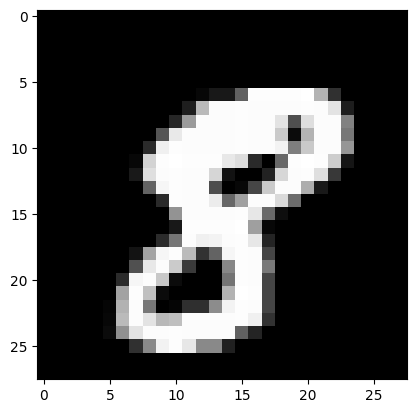

In [14]:
plt.imshow(image,cmap="gray")

In [15]:
#给这张图片加噪音
noisy_image = image + 0.2 * np.random.randn(*image.shape) #随机创建一个和image维度一样的矩阵
noisy_image = np.clip(noisy_image,0,1) #把noisy_image的所有值限制在0，1之间

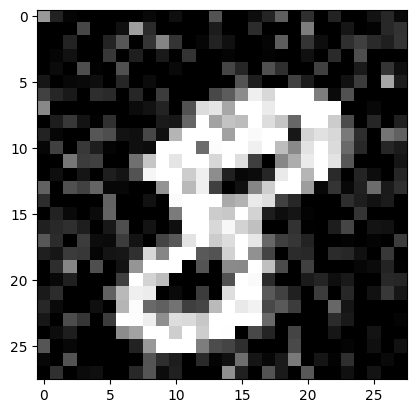

In [16]:
plt.imshow(noisy_image,cmap="gray")

# Data Preparation 

In [17]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

<img src="dataset.png" alt="drawing" width="400"/>

In [18]:
class MNIST_AE_Dataset(Dataset): #继承自Dataset这个类
    
    def __init__(self, csv_file, noise_factor = 0.2, transform = None):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img, (28,28,1)) / 255
        
        nsy_image = img + self.noise_factor * np.random.randn(*img.shape)
        nsy_image = np.clip(nsy_image,0,1)
        sample = (nsy_image, img)
        
        if  self.transform:
            sample=self.transform(sample)
        
        return sample
        

### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [19]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv', 0.2, ToTensorForAE())

In [20]:
print("Size of train set : %d" % len(trainset))

Size of train set : 42000


In [21]:
noisy_img, ori_img = trainset[41]

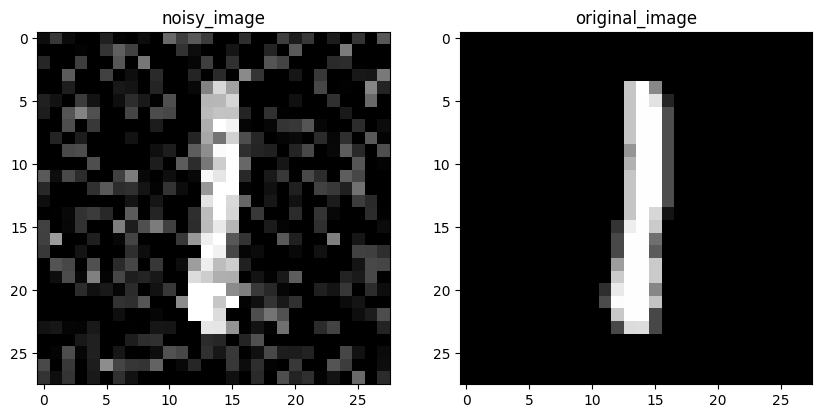

In [22]:
show_image(noisy_img, ori_img)

# Load dataset into batches

In [23]:
from torch.utils.data import DataLoader

In [24]:
trainloader = DataLoader(trainset, batch_size =16, shuffle = True)

In [25]:
dataiter = iter(trainloader) #
noisy_img, ori_img = next(dataiter) # 在Python3中，next是一个方法而不是一个函数

print("Shape of loading one batch : {}" .format(noisy_img.shape))
print("Total number of batches : {}".format(len(trainloader)))
print("Total number of examples : {}".format(len(trainloader.dataset)))



Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total number of batches : 2625
Total number of examples : 42000


# Create AutoEncoder Model
<img src="pic3.png" alt="drawing" width="800"/>

In [26]:
from torch import nn
from torchsummary import summary
# 在这一部分我们要创建两个网络，一个encoder网络一个decoder网络

In [27]:
def Encoder():
    encoder = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1), #一个卷积层，same padding
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1), #一个卷积层，same padding
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
    )
    
    return encoder

In [28]:
# 这个是encoder的一个反向过程
def Decoder():
    decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2,2), stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(2,2), stride=2),
        nn.Sigmoid()
    )
    
    return decoder

In [29]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__() # 调用父类构造函数
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, inp_imgs):
        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)
        
        return decoder_out


model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [30]:
summary(model, input_size=(1, 28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

In [31]:
from tqdm import tqdm # 一个进度条库

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss() # mean squared loss
epochs=10


In [32]:
for i in range(epochs):
    train_loss= 0.0
    model.train()
    for batch in tqdm(trainloader):
        noisy_img, ori_img = batch
        
        denoised_img = model(noisy_img)
        loss = criterion(denoised_img, ori_img)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(trainloader)
    print("epoch : {}  Train loss : {}".format(i+1, avg_train_loss))
    

100%|██████████| 2625/2625 [00:15<00:00, 166.22it/s]


epoch : 1  Train loss : 0.011413513411368642


100%|██████████| 2625/2625 [00:15<00:00, 166.11it/s]


epoch : 2  Train loss : 0.005453453929296562


100%|██████████| 2625/2625 [00:15<00:00, 168.31it/s]


epoch : 3  Train loss : 0.005091004007983776


100%|██████████| 2625/2625 [00:15<00:00, 166.55it/s]


epoch : 4  Train loss : 0.004895964246598028


100%|██████████| 2625/2625 [00:15<00:00, 164.59it/s]


epoch : 5  Train loss : 0.004761487754771397


100%|██████████| 2625/2625 [00:15<00:00, 166.77it/s]


epoch : 6  Train loss : 0.0046782580676178135


100%|██████████| 2625/2625 [00:15<00:00, 166.60it/s]


epoch : 7  Train loss : 0.004610641027135509


100%|██████████| 2625/2625 [00:16<00:00, 163.31it/s]


epoch : 8  Train loss : 0.0045614608721364115


100%|██████████| 2625/2625 [00:15<00:00, 166.74it/s]


epoch : 9  Train loss : 0.004516369183592143


100%|██████████| 2625/2625 [00:15<00:00, 164.46it/s]

epoch : 10  Train loss : 0.00448664882894428


# Plot Results

torch.Size([1, 28, 28])


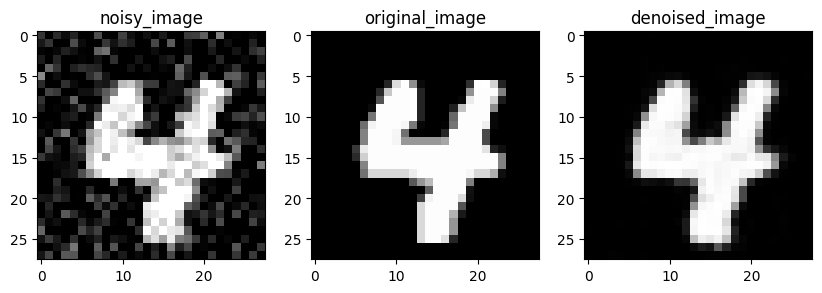

In [34]:
model.eval() # model.eval() 是确保你的模型在评估或测试阶段正确处理 dropout 和 batch normalization 等层的关键方法。

with torch.no_grad():
    dataiter = iter(trainloader)
    sample = next(dataiter)
    
    noisy_img, ori_img = sample
    
    index = 7
    
    denoised_img = model(noisy_img[index].unsqueeze(0)) # (c,h,w) -> (bs,c,h,w)
    print(denoised_img.squeeze(0).shape)
    
    show_image(noisy_img[index], ori_img[index], denoised_img.squeeze(0))



# 下一步练习，
# 1. 把数据集分成train set, cv set, test set
# 2. 给输入图片colorization，输入黑白图片，给出彩色图片




